In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
plt.style.use("ggplot")
from subprocess import check_output

In [ ]:
df = pd.read_csv('forecasting.csv').set_index('Time')
df.index = pd.to_datetime(df.index)
df.head()

Text(0,0.5,'OGTT Test')

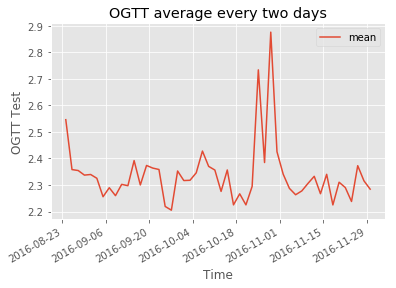

In [17]:
df["Magnitude"].resample("2D").apply([np.mean]).plot()
plt.title("OGTT average every two days")
plt.ylabel("OGTT Test")

Text(0,0.5,'OGTT Test')

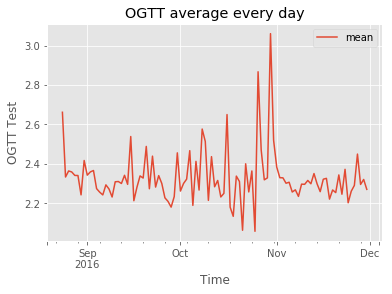

In [12]:
df["Magnitude"].resample("D").apply([np.mean]).plot()
plt.title("OGTT average every day")
plt.ylabel("OGTT Test")

In [13]:
# Pandas series with magnitudes greater than 3.0
magn3 = df.ix[df["Magnitude"] >= 3.0, "Magnitude"]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0,0.5,'OGTT Test')

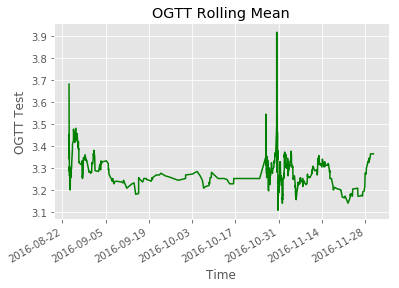

In [14]:
pd.Series.rolling(magn3, window=25).mean().plot(style="-g")
plt.title("OGTT Rolling Mean")
plt.ylabel("OGTT Test")

In [15]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

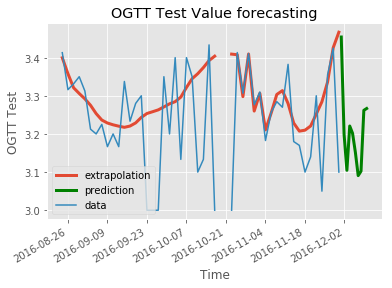

In [65]:
n_predict = 300
resample_period = "2D"
predict_period = "D"

pred = pd.Series(
    fourierExtrapolation(magn3, n_predict),
    index=magn3.index.append(pd.DatetimeIndex(start="2016-12-01", freq="45T", periods=n_predict))
)

fig = plt.figure()

fitted = pred[:-n_predict].resample(resample_period).mean()
predict = pred[-n_predict:].resample(predict_period).mean()

fitted.plot(linewidth=3, label="extrapolation")
predict.plot(linewidth=3, style="-g", label="prediction")
magn3.resample(resample_period).mean().plot(label="data")

plt.title("OGTT Test Value forecasting")
plt.ylabel("OGTT Test")
plt.legend(loc="lower left")